In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [4]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [5]:
cache = analysis.refresh_cache()
print(cache.keys())

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses', 'task_conditional_analyses', 'task_conditional_multiplicative_only_analyses', 'task_conditional_additive_only_analyses', 'task_conditional_weights', 'task_conditional_multiplicative_only_weights', 'task_conditional_additive_only_weights', 'forgetting_exp_decay_params', 'baseline_ratio_curriculum_analyses', 'baseline_power_curriculum_analyses', 'epochs_to_completion', 'ratio_curriculum_1_5_analyses', 'power_curriculum_2_analyses'])


In [14]:
six_replications_updated_analyses = cache['six_replications_updated_analyses']
control_updated_analyses = cache['updated_control_analyses']
query_mod_updated_analyses = cache['query_mod_updated_analyses']
baseline_ratio_curriculum_analyses = cache['baseline_ratio_curriculum_analyses']
baseline_power_curriculum_analyses = cache['baseline_power_curriculum_analyses']
ratio_curriculum_1_5_analyses = cache['ratio_curriculum_1_5_analyses']
power_curriculum_2_analyses = cache['power_curriculum_2_analyses']
epochs_to_completion = cache['epochs_to_completion']

# Combined Figure

In [15]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0


def create_combined_figure(analyses):
    title_font_dict = TITLE_FONT_DICT.copy()
    title_font_dict['pad'] = 10

    multi_plot_font_dict = FONT_DICT.copy()
    multi_plot_font_dict['fontsize'] = 18

    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(hspace=0.4, wspace=0.35)


    raw_accuracy_axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
    plots.both_raw_accuracy_plots(analyses, '',
                                  shade_error=True, font_dict=multi_plot_font_dict, log_x=True,
                                  new_task_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                  first_task_colormap=NUM_TIMES_TRAINED_COLORMAP, title_font_dict=title_font_dict,
                                  hline_y=0.95, first_task_title='', new_task_title='', add_colorbars=False,
                                  external_axes=raw_accuracy_axes)


    examples_to_criterion_axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
    LOG_PLOT_YLIM = (7.75, 13.25)
    plots.plot_processed_results_all_dimensions(analyses, data_index=1, 
                                                title='',
                                                ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=(60, 60, 60, 180), shade_error=True,
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                dimension_names=('',), dimension_indices=(3,),
                                                # num_tasks_trained_highlight_first_time='highlight', 
                                                add_colorbars=False,
                                                title_font_dict=TITLE_FONT_DICT, external_axes=examples_to_criterion_axes,
                                                plot_regression='print', num_tasks_to_plot_tasks_trained=1,
                                                tasks_trained_y_label='Log(New task trials to criterion)')


    accuracy_22point5k_axes = (plt.subplot(NROWS, NCOLS, 3), plt.subplot(NROWS, NCOLS, NCOLS + 3))
    ACCURACY_PLOT_YLIM = (0.5, 1.0)
    plots.plot_processed_results_all_dimensions(analyses, data_index=3, 
                                                title='', #'New episode, 22.5k accuracy, baseline model',
                                                sem_n=(60, 60, 60, 180), shade_error=True, ylim=ACCURACY_PLOT_YLIM, 
                                                plot_y_label='Accuracy\nafter 22.5k trials',
                                                tasks_trained_y_label='New task accuracy\nafter 22.5k trials',
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                dimension_names=('',), dimension_indices=(3,),
                                                # num_tasks_trained_highlight_first_time='highlight',
                                                title_font_dict=TITLE_FONT_DICT, num_tasks_to_plot_tasks_trained=1,
                                                external_axes=accuracy_22point5k_axes)

    TEXT_POSITIONS = [(0.06, 0.85), (0.06, 0.42),
                      (0.3365, 0.85), (0.3365, 0.42),
                      (0.625, 0.85), (0.625, 0.42)]

    subfigure_text_font_dict = FONT_DICT.copy()
    subfigure_text_font_dict['fontsize'] += 4
    subfigure_text_font_dict['color'] = '#808080'
    subfigure_text_font_dict['weight'] = 'bold'

    num_subfigures = 6
    for i in range(num_subfigures):
        pos = TEXT_POSITIONS[i]
        plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
                 subfigure_text_font_dict, transform=figure.transFigure)


    # plots.save('aaai/combined_figure_python.pdf')
    plt.show()

# Baseline

log(y) = -1.603 log(x) + 11.71
log(y) = -0.447 log(x) + 12.3


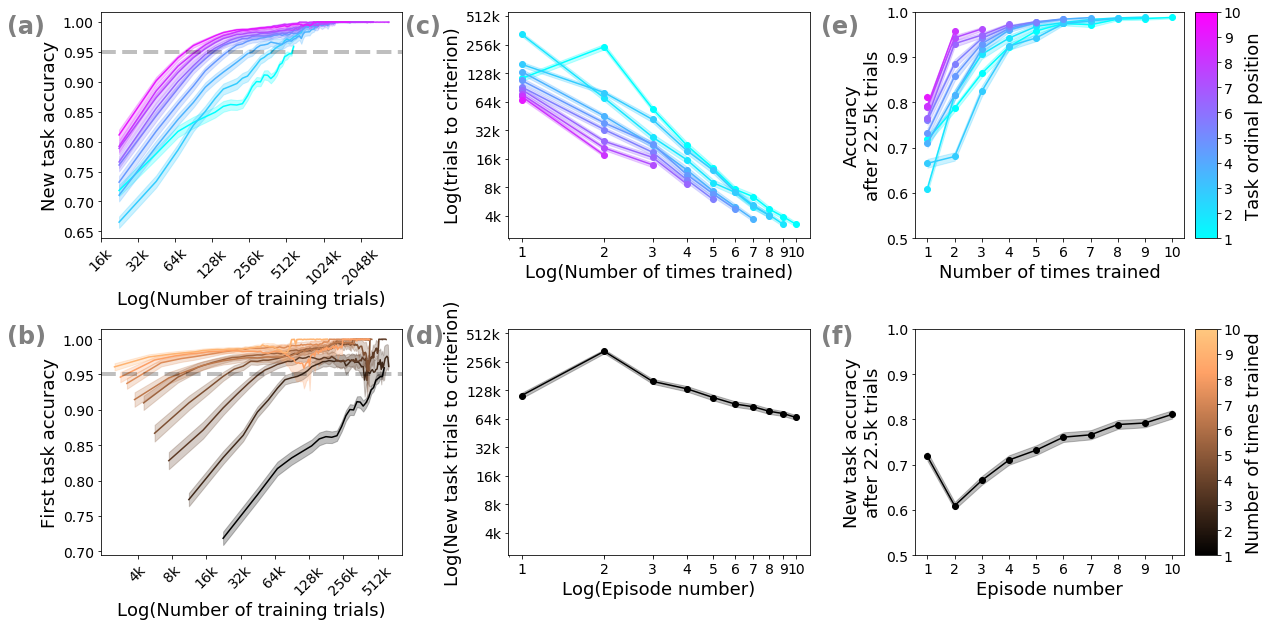

In [16]:
create_combined_figure(six_replications_updated_analyses)

# Heterogeneous dimensions control

log(y) = -1.531 log(x) + 11.45
log(y) = -0.525 log(x) + 12.3


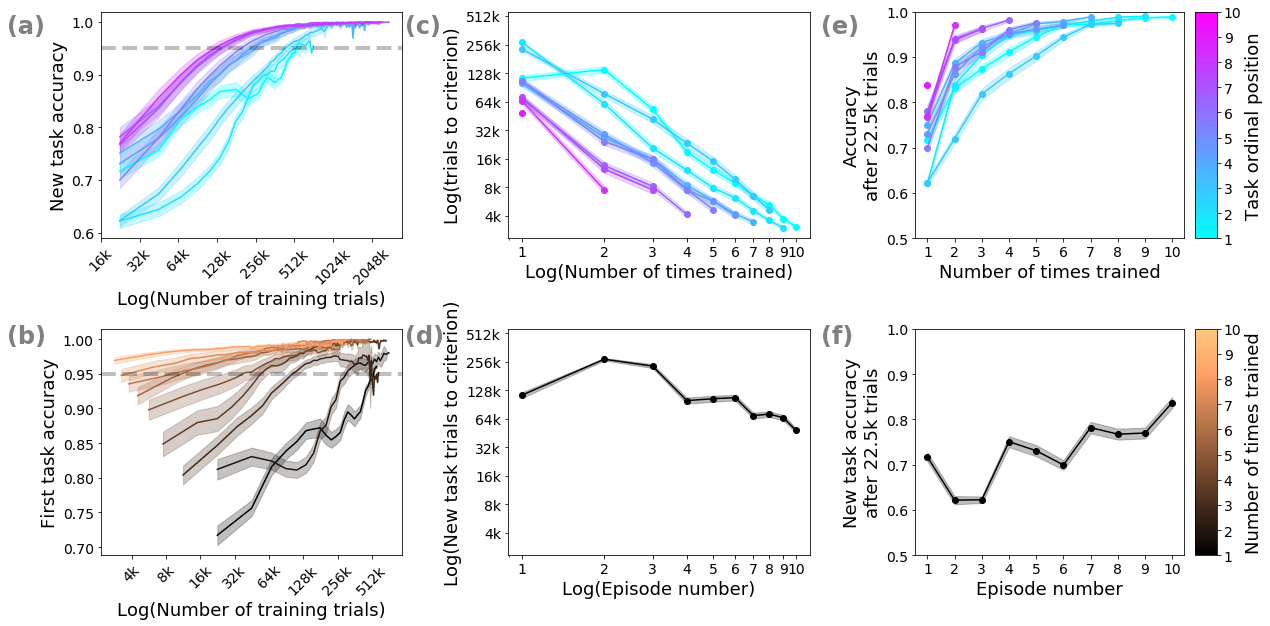

In [17]:
create_combined_figure(control_updated_analyses)

# Ratio curriculum

log(y) = -1.384 log(x) + 11.5
log(y) = -0.349 log(x) + 12.2


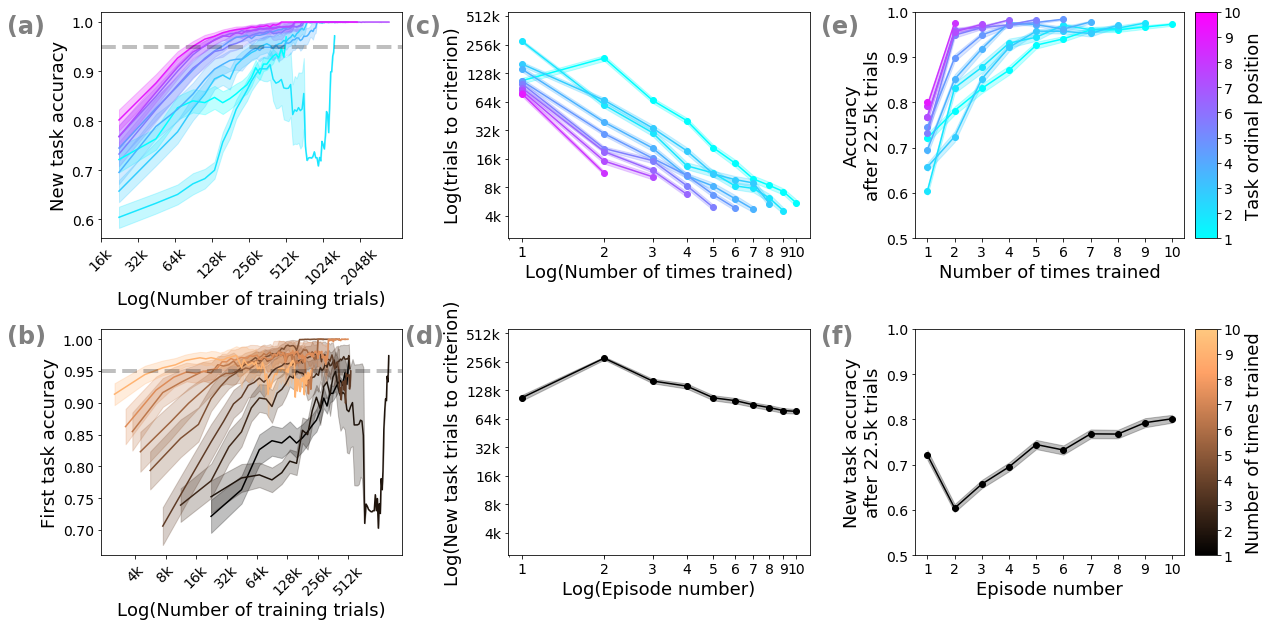

In [18]:
create_combined_figure(baseline_ratio_curriculum_analyses)

# Ratio curriculum, suboptimal ratio

log(y) = -1.02 log(x) + 11.23
log(y) = -0.348 log(x) + 12.2


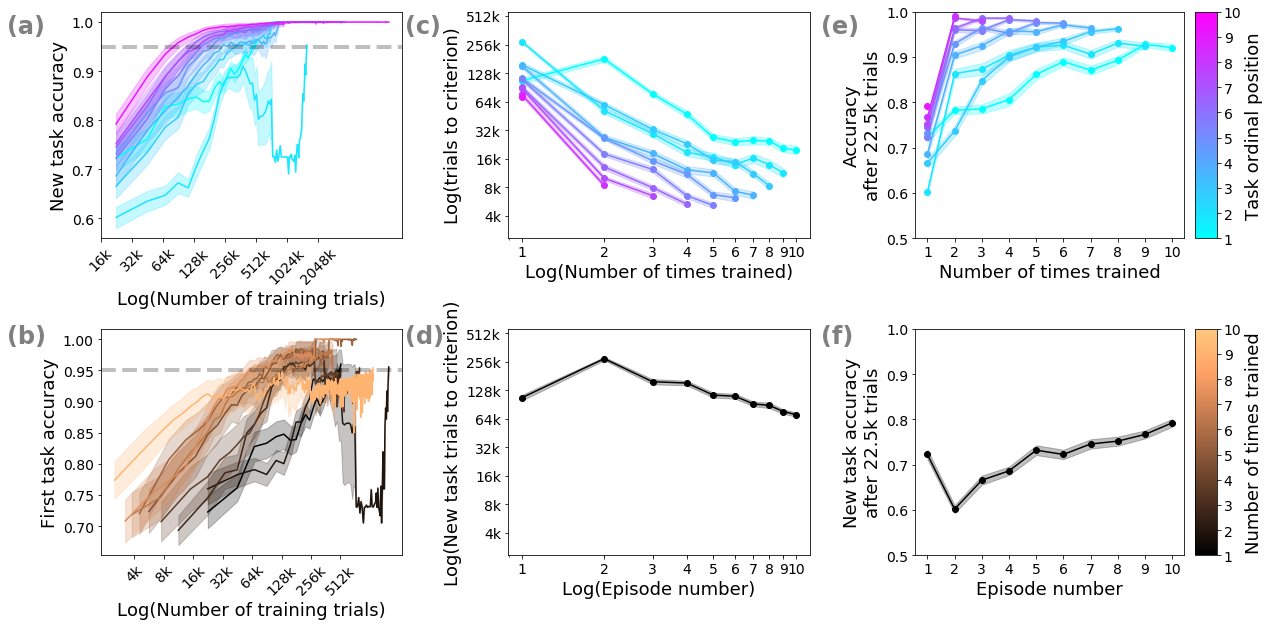

In [19]:
create_combined_figure(ratio_curriculum_1_5_analyses)

# Power curriculum

log(y) = -1.417 log(x) + 11.5
log(y) = 0.0589 log(x) + 11.6


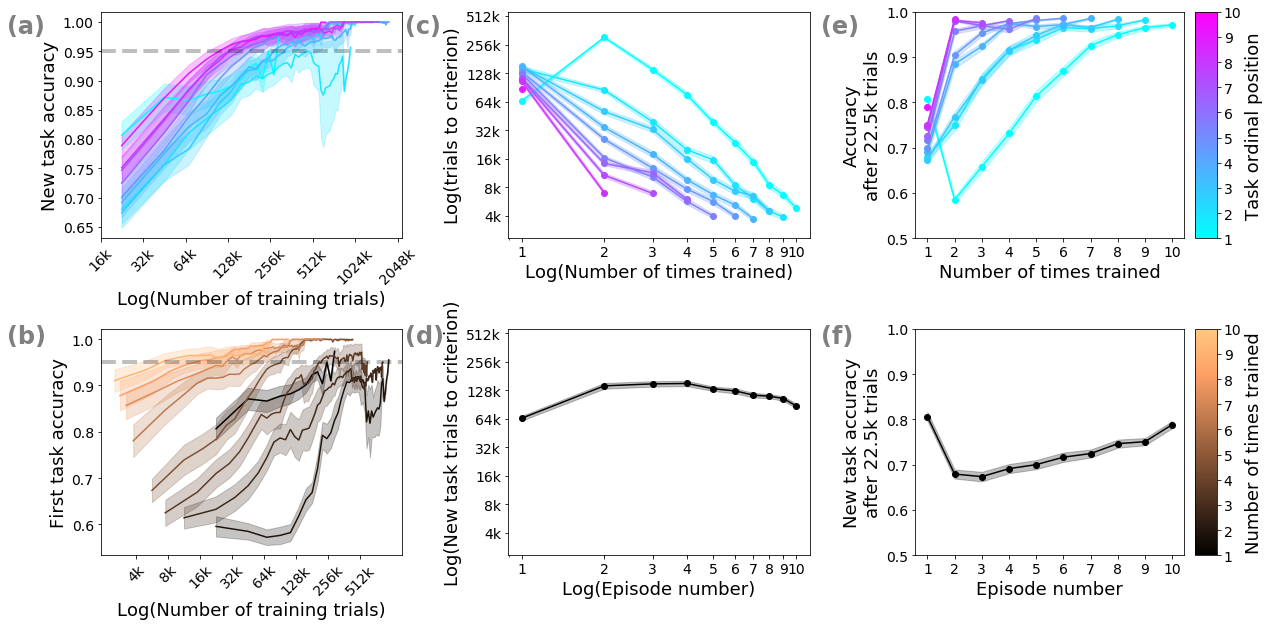

In [20]:
create_combined_figure(baseline_power_curriculum_analyses)

# Power curriculum, different exponent

log(y) = -0.4337 log(x) + 11.03
log(y) = -0.172 log(x) + 11.5


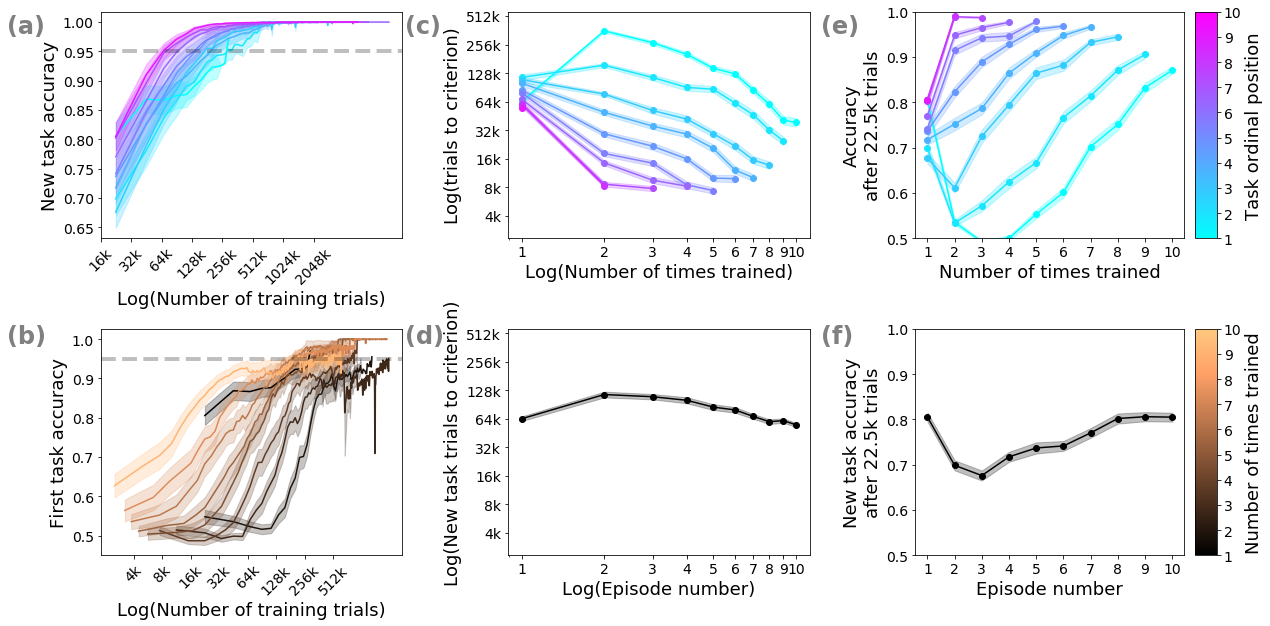

In [21]:
create_combined_figure(power_curriculum_2_analyses)

# Taking a first stab at plotting the epochs to completion

In [23]:
epochs_to_completion.keys()

dict_keys(['baseline', 'heterogeneous', 'ratio_curriculum', 'ratio_curriculum_1_5', 'power_curriculum', 'power_curriculum_2'])

In [27]:
epochs_to_completion['baseline']['raw'].combined

ResultSet(name='epochs_to_completion', mean=array([  7.2       ,  30.55555556,  46.07222222,  65.86666667,  85.84444444, 107.64444444, 131.91111111, 152.58888889, 170.73333333, 185.65555556]), std=array([ 6.12680812, 38.0854627 , 41.17739814, 48.09809421, 56.64193796, 67.89007637, 79.73193205, 89.29114606, 94.10210766, 97.67282815]))

0

In [47]:
DEFAULT_COLORMAP = plt.get_cmap('Dark2')


def single_ax_epochs_to_completion(data, condition_index, ax, raw_or_log, 
                                   cm=DEFAULT_COLORMAP, plot_sem=True, sem_n=10):
    for i, name in enumerate(data.keys()):
        y = data[name][raw_or_log][condition_index]
        if y is not None:
            x = np.arange(y.mean.shape[0]) + 1
            c = cm(i)

            ax.plot(x, y.mean, color=c, label=name)

            if plot_sem:
                sem = y.std / (sem_n ** 0.5)
                ax.fill_between(x, y.mean - sem, y.mean + sem, color=c, alpha=0.25)
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Epochs')
    ax.set_xticks(x)

    
def plot_epochs_to_completion(data, condition, cm=DEFAULT_COLORMAP, plot_sem=True, sem_n=10):
    figure = plt.figure(figsize=(16, 6))

    condition_index = analysis.CONDITION_ANALYSES_FIELDS.index(condition)
    
    raw_ax = plt.subplot(1, 2, 1)
    single_ax_epochs_to_completion(data, condition_index, raw_ax, 'raw',
                                  cm=cm, plot_sem=plot_sem, sem_n=sem_n)
    raw_ax.set_title('Raw')
    
    log_ax = plt.subplot(1, 2, 2)
    single_ax_epochs_to_completion(data, condition_index, log_ax, 'log',
                                  cm=cm, plot_sem=plot_sem, sem_n=sem_n)
    log_ax.set_title('Log')
    
    legend_lines = [matplotlib.lines.Line2D([0], [0], color=cm(i), lw=4) for i in range(len(data.keys()))]
    plt.legend(legend_lines, data.keys(), bbox_to_anchor=(1.04,1), loc="upper left")
    plt.suptitle(condition.title())
    

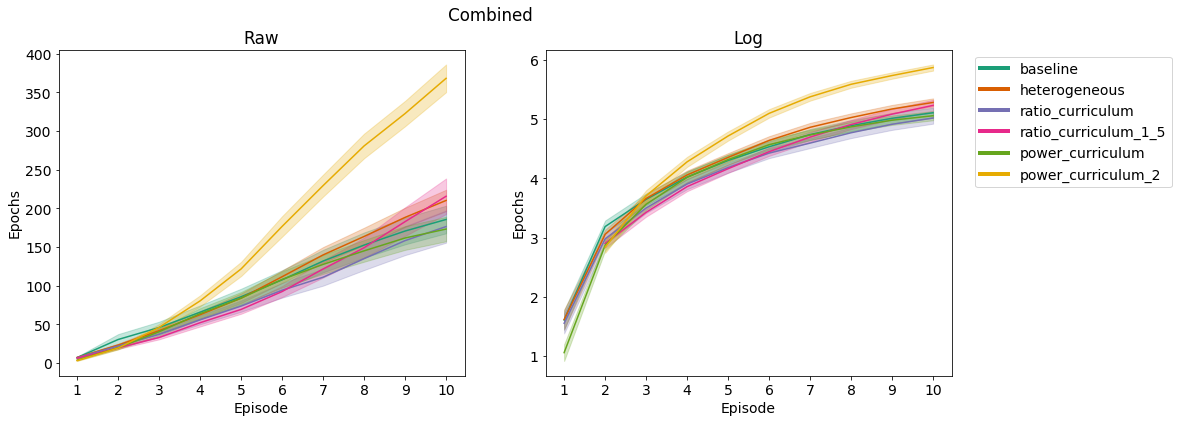

In [48]:
plot_epochs_to_completion(epochs_to_completion, analysis.COMBINED, sem_n=30)

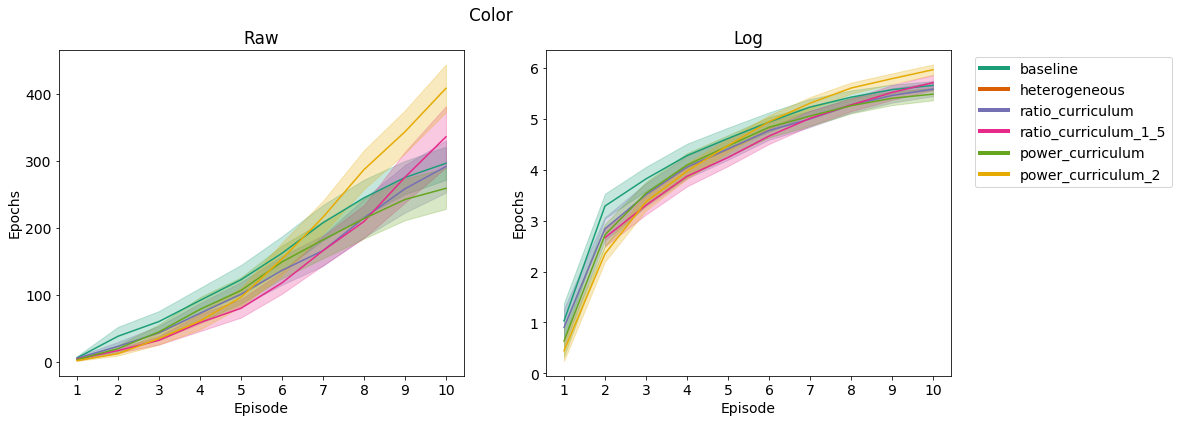

In [49]:
plot_epochs_to_completion(epochs_to_completion, analysis.COLOR)

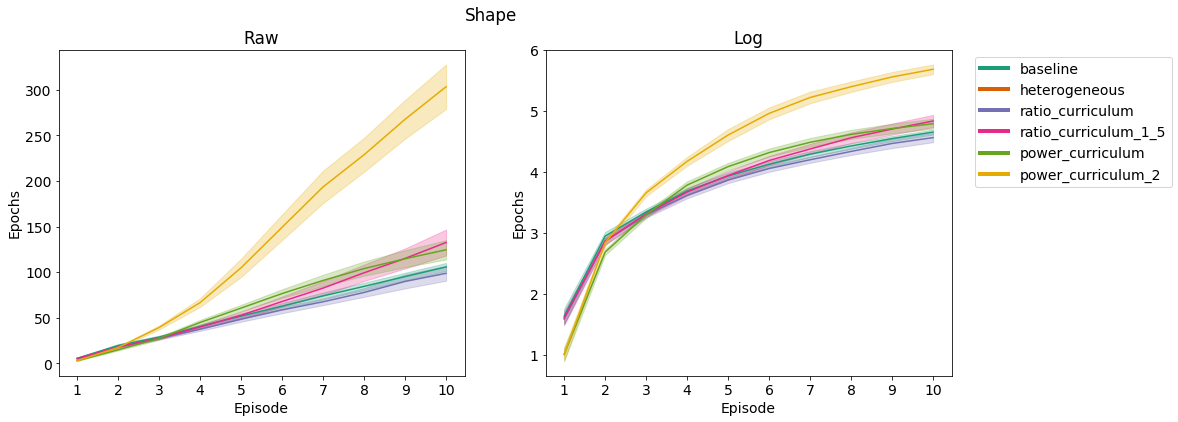

In [50]:
plot_epochs_to_completion(epochs_to_completion, analysis.SHAPE)

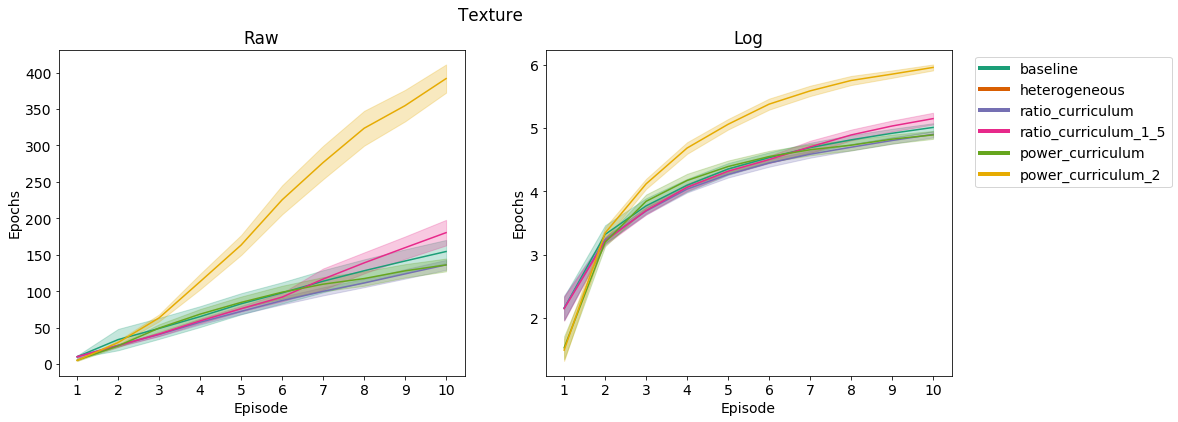

In [51]:
plot_epochs_to_completion(epochs_to_completion, analysis.TEXTURE)